# 16D revisited

With better graphs this time.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
# seed = np.random.randint(1, 2**32 - 1)
seed = 900594808
set_all_seeds(seed)
print(seed)

900594808


Interesting seeds:
- `900594808`

## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, use_act=True, dim=32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(2, dim, use_act=use_act),
            LinearLayer(dim, 1, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

Going to sample $x_1$ (mass) and $x_2$ (acceleration) such that their product is uniformly distributed.

In [4]:
eps = 0.5

Y = torch.rand(10000)
X = torch.empty(10000, 2)
X[:, 0] = Y / (torch.rand(10000) * (1 - eps) + eps)
X[:, 1] = Y / X[:, 0]

# need to randomly swap x1 and x2 so that they're identically distributed - can do this because their product is commutative
mask = torch.rand(10000) < 0.5
swap_vals = X[:, 0][mask]
X[:, 0][mask] = X[:, 1][mask]
X[:, 1][mask] = swap_vals

assert torch.allclose(X[:, 0] * X[:, 1], Y)

Y = Y[:, None]
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

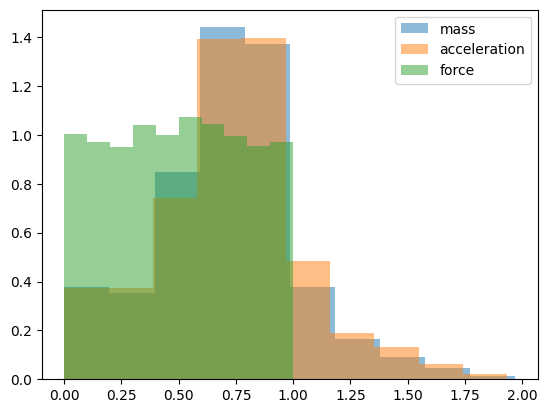

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

In [6]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 2]),
 torch.Size([8000, 1]),
 torch.Size([2000, 2]),
 torch.Size([2000, 1]))

## Training

I'll just do full gradient descent to keep things simple.

In [7]:
N = 4000  # number of epochs

model = Net(use_act=True, dim=16)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [8]:
def plot_loss(train_loss, valid_loss):
    _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


def get_preds(model):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.flatten().numpy()
    y_targs = Y_valid.flatten().numpy()

    return y_preds, y_targs


def get_valid_loss(model, loss_func):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs):
    _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()

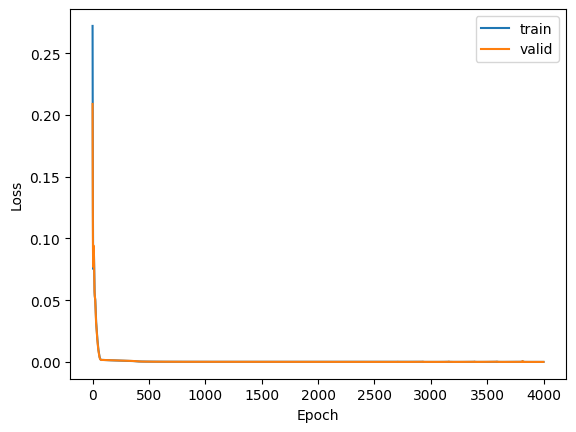

In [9]:
plot_loss(df["train_loss"], df["valid_loss"])

In [10]:
y_preds, y_targs = get_preds(model)

In [11]:
get_valid_loss(model, loss_func)

tensor(5.0738e-05)

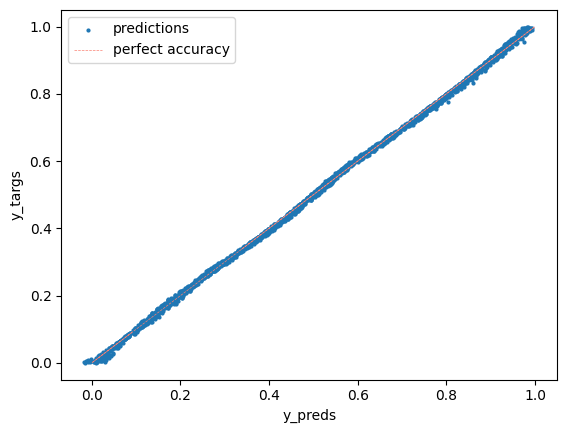

In [12]:
plot_results(y_preds, y_targs)

## Introspection

In [13]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=2, out_features=16, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=16, out_features=1, bias=True)
    )
  )
)

In [14]:
for name, param in model.named_parameters():
    print(name, "\n", param.data, "\n")

layers.0.linear.weight 
 tensor([[ 0.7963,  0.8137],
        [ 0.4128,  0.6832],
        [-0.4457,  0.4241],
        [-0.5226,  0.2417],
        [-0.3957, -0.0578],
        [ 0.0049,  0.4913],
        [-0.5997,  0.1203],
        [-0.4375, -0.6223],
        [-0.3092,  0.4511],
        [ 0.5343, -0.3207],
        [-0.5844,  0.6126],
        [-0.0613, -0.4299],
        [-0.1793,  0.9808],
        [-0.8130,  0.8415],
        [ 0.3629,  0.3711],
        [-0.5003,  0.1429]]) 

layers.0.linear.bias 
 tensor([-0.8420, -0.1193, -0.2145,  0.5789, -0.5868,  0.3354, -0.1247,  0.1990,
         0.3831,  0.6323,  0.1868,  0.7249,  0.2401, -0.1492, -0.5696, -0.2452]) 

layers.1.linear.weight 
 tensor([[ 0.3114,  0.1666, -0.3300, -0.1789, -0.2131,  0.3424,  0.2431, -0.1806,
          0.1824,  0.0308, -0.4332, -0.3817,  0.2317, -0.2799,  0.6932,  0.0599]]) 

layers.1.linear.bias 
 tensor([0.0643]) 



### Inspect intermediate values

In [15]:
from collections import OrderedDict
import torch
import torch.nn as nn


def capture_intermediate_outputs(model, input_tensor):
    """
    Captures the intermediate outputs of a PyTorch model.

    Args:
        model: A PyTorch model.
        input_tensor: A PyTorch tensor of shape (batch_size, *).
    Returns:
        A dictionary mapping layer names to intermediate outputs.
    """
    intermediate_values = OrderedDict()

    def hook_fn(module, input, output, name):
        if isinstance(module, nn.Linear):
            weight = module.weight
            input_value = input[0]
            intermediate_output = input_value.matmul(weight.t())
            intermediate_values[f"{name}.weight"] = intermediate_output
            intermediate_values[f"{name}.bias"] = output
        else:
            intermediate_values[name] = output

    hooks = []
    for name, layer in model.named_modules():
        hook = layer.register_forward_hook(
            lambda module, input, output, name=name: hook_fn(module, input, output, name)
        )
        hooks.append(hook)

    with torch.inference_mode():
        _ = model(input_tensor)

    for hook in hooks:
        hook.remove()

    filtered_values = {k: t for k, t in intermediate_values.items() if len(k.split(".")) > 2}
    return filtered_values


# a function that uses capture_intermediate_outputs to give a nice printed summary of the model outputs and parameters
def print_model_summary(model, input_tensor):
    intermediate_values = capture_intermediate_outputs(model, input_tensor)

    for k, v in intermediate_values.items():
        print(f"{k}: {v}")

/var/folders/5z/c8p82vrj5f333s_5w192fbw80000gn/T/ipykernel_97407/3610279510.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle in which to fit the subplots


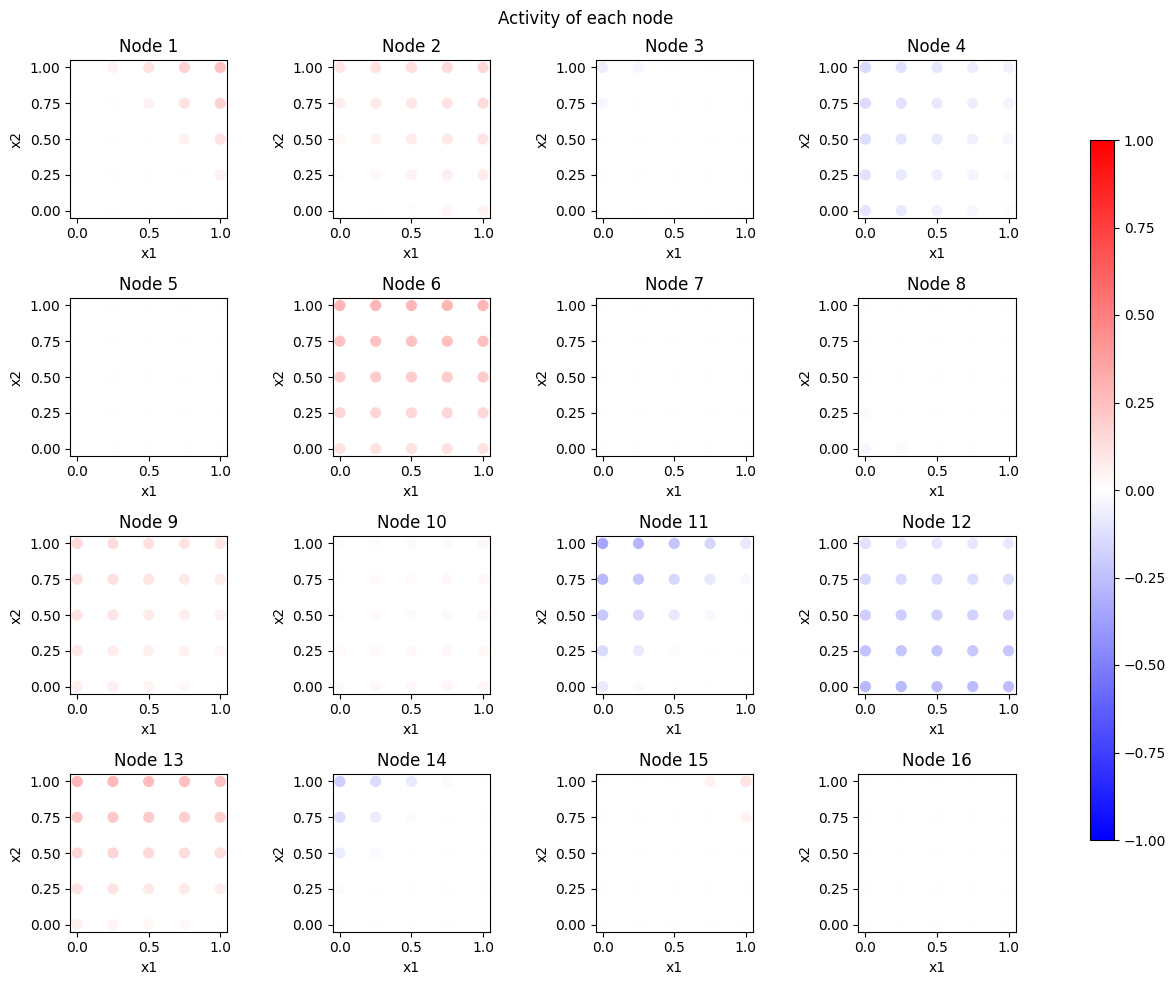

In [16]:
N = 5
eps = 0.05
pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)

outputs = capture_intermediate_outputs(model, torch.as_tensor(pairs).float())
lws = model.state_dict()["layers.1.linear.weight"]
acts = outputs["layers.0.act"]
acts = acts * lws[0, :]  # linear weighting now (I know they're not technically activations anymore)

fig, axes = plt.subplots(4, 4, figsize=(12, 10))  # Increase the width to make space for the colorbar
axes = axes.flatten()

# Determine global min and max activations to ensure consistent colour scaling
vmin, vmax = acts.min(), acts.max()

for i in range(acts.shape[1]):
    col = acts[:, i]
    activated_mask = acts[:, i].abs() > eps  # really trying to focus on the activated areas
    activated_mask = torch.ones(col.shape, dtype=bool)
    sc = axes[i].scatter(
        pairs[activated_mask, 0],
        pairs[activated_mask, 1],
        c=col[activated_mask],
        cmap="bwr",
        s=50,
        norm=plt.Normalize(vmin=-1, vmax=1),
    )

    axes[i].set_title(f"Node {i+1}")
    axes[i].set_xlabel("x1")
    axes[i].set_ylabel("x2")
    axes[i].set_aspect("equal")
    axes[i].set_xlim(-0.05, 1.05)
    axes[i].set_ylim(-0.05, 1.05)

# Position the colorbar on the right of the last subplot
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cbar_ax)

fig.suptitle("Activity of each node")
fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle in which to fit the subplots

I find these plots great.

### Some observations
- can see that almost half of the nodes really are typically essentially redundant
- sometimes the nodes act to essentially cancel eachother out (I suppose in the absence of regularisation like weight decay this is totally valid)
- does still often spread the work load around multiple nodes leading to very similar looking outputs - again, there is no constraint on complexity here

In [17]:
# torch.save(model.state_dict(), 'models/e-4-.pth')